<a href="https://colab.research.google.com/github/vlnchk/urban-palm-tree/blob/main/Has_the_client_subscribed_a_term_deposit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи открыл ли клиент вклад 

* Загрузка данных и их анализ


Будем решать задачу определения оттоковых клиентов,  а именно, *по характеристикам клиентов некоторого банка будем определять, собираются ли клиенты сменить оператора мобильной связи или нет*.

## <font color='green'>1. Загрузка данных и их первичный анализ</font>

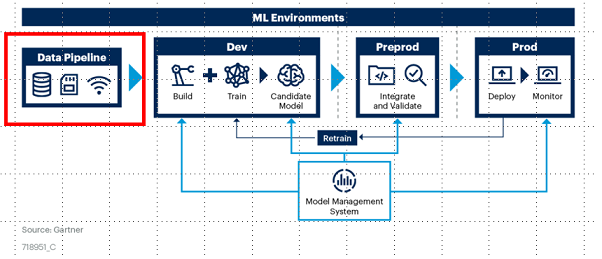

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-05-22 19:08:26--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-05-22 19:08:27 (491 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [3]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2,270 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,344 kB]
Get:14 htt

In [4]:
import psycopg2

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [5]:
import pandas as pd

query = "SELECT * from public.bank_deposit"
data = pd.read_sql_query(query, conn)

conn.close()

Посмотрим на данные.

Описание данных клиентов:

* age (numeric): количество полных лет
* job : тип занимаемой должности (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* marital : семейное положение (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* default: имеется ли любой вид кредитования? (categorical: 'no','yes','unknown')
* housing: имеется ли ипотека? (categorical: 'no','yes','unknown')
*loan: имеется ли персональный кредит? (categorical: 'no','yes','unknown')

Related with the last contact of the current campaign:

* contact: вид контакта с клиентом (categorical: 'cellular','telephone') 
* month: в каком месяце было сделано предыдущее предложение (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* day_of_week: день недели было предыдущее предложение (categorical: 'mon','tue','wed','thu','fri')
* duration: продолжительность предыдущего общения в секундах. Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Other attributes:

* campaign: количество контактов по этой маркетинговой кампании с этим клиентов(numeric, includes last contact)
* pdays: количество дней, прошедших с предыдущего предложения(число; 999 означает, что раньше не предлагали)
* previous: количество контактов с этим лиентов в другие маркетинговые кампании(numeric)
* poutcome: результат предыдущего предложения (categorical: 'failure','nonexistent','success')
* balance - закодированное название личной числовой характеристики клиента

In [10]:
data.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59.0,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042.0,1,-1,0,unknown,yes
1,55.0,services,married,secondary,no,2476,yes,no,unknown,5,may,NaN,1,-1,0,unknown,yes


In [8]:
data.shape

(11162, 17)

In [9]:
data.dtypes

age          float64
job           object
marital       object
education     object
default       object
balance        int64
housing       object
loan          object
contact       object
day            int64
month         object
duration     float64
campaign       int64
pdays          int64
previous       int64
poutcome      object
deposit       object
dtype: object

# Разведочный анализ данных

## 1. Оценка качества данных
* пропущенные значения
* ошибочные значения

In [13]:
len(data)

11162

Посмотрим, есть ли в данных пропущенные значения.

In [14]:
data.isna().sum()

age          1967
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
day             0
month           0
duration     1498
campaign        0
pdays           0
previous        0
poutcome        0
deposit         0
dtype: int64

In [45]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,9139.000000,11092.000000,11092.000000,9604.000000,11092.000000,11092.000000,11092.000000
mean,41.197396,1525.907411,15.659304,371.971158,2.506671,51.302651,0.833393
std,11.940365,3224.485911,8.415306,345.773430,2.719981,108.643551,2.296287
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,139.000000,1.000000,-1.000000,0.000000
50%,39.000000,549.000000,15.000000,254.000000,2.000000,-1.000000,0.000000
75%,49.000000,1704.000000,22.000000,496.250000,3.000000,17.750000,1.000000
max,95.000000,81204.000000,31.000000,3284.000000,63.000000,854.000000,58.000000


Удалим столбец pre

Заменим пропуски age и duration медианным значением

In [46]:
median = data['age'].median()

data['age'].fillna(median, inplace=True)

In [47]:
median = data['duration'].median()

data['duration'].fillna(median, inplace=True)

In [48]:
data.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

Идентифицируем ошибочные значения

In [21]:
data.describe(include='object') # категориальные колонки

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,5881,9702,8042,2824,8326,5873


In [33]:
data['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Удалим строки со значением работы unknown   

In [39]:
data = data[data['job'] != 'unknown']

In [40]:
data['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

In [38]:
data['marital'].value_counts() 

married     6351
single      3518
divorced    1293
Name: marital, dtype: int64

In [37]:
data['education'].value_counts()  

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

Заполним строки со значением education = 'unknown' новым значением 'primary'

In [41]:
data.loc[data['education'] == 'unknown', 'education'] = 'primary'

In [42]:
data['education'].value_counts()  

secondary    5461
tertiary     3680
primary      1951
Name: education, dtype: int64

In [36]:
data['contact'].value_counts()

cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64

Заполним строки со значением contact = 'unknown' новым значением 'cellular'

In [43]:
data.loc[data['contact'] == 'unknown', 'contact'] = 'cellular'

In [44]:
data['contact'].value_counts()

cellular     10329
telephone      763
Name: contact, dtype: int64

In [51]:
data['poutcome'].value_counts()

unknown    8275
failure    1220
success    1061
other       536
Name: poutcome, dtype: int64

Удалим столбец poutcome

In [52]:
data = data.drop('poutcome', axis=1)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>, <Axes: >, <Axes: >]],
      dtype=object)

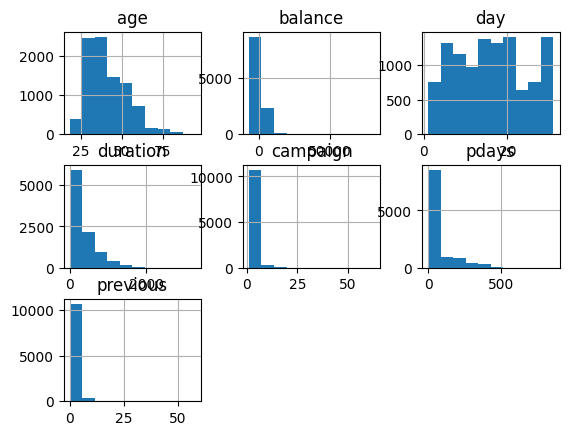

In [27]:
data.hist()

Посмотрим на матрицу корреляций

In [53]:
corr = data.corr() # строим матрицу корреляций

corr.style.background_gradient(cmap='coolwarm')

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.098506,0.004239,0.003012,-0.005285,-0.001325,0.016719
balance,0.098506,1.000000,0.009914,0.024601,-0.014836,0.017893,0.031464
day,0.004239,0.009914,1.000000,-0.013744,0.136007,-0.076278,-0.058574
duration,0.003012,0.024601,-0.013744,1.000000,-0.037789,-0.030884,-0.024660
campaign,-0.005285,-0.014836,0.136007,-0.037789,1.000000,-0.102041,-0.049019
pdays,-0.001325,0.017893,-0.076278,-0.030884,-0.102041,1.000000,0.507111
previous,0.016719,0.031464,-0.058574,-0.024660,-0.049019,0.507111,1.000000


Коррелирующих значений не выявлено — day, pdays и previous — не могут быть использованы для подсчета корреляций.

In [57]:
data.to_csv("yn_deposit.csv", index=False)